In [4]:
%matplotlib inline


迁移学习教程
==========================
在本教程中，你将学到如何使用迁移学习训练网络。

了解更多关于迁移学习的内容[cs231n notes](http://cs231n.github.io/transfer-learning/)

实际中，很少有人从头开始训练卷积神经网络。因为很难有足够规模的数据集。相反地，在很大的数据集上预训练一个卷积神经网络是常见的。例如 ImageNet，包含 1.2 百万个图像与 1000 个类别。然后使用卷积神经网络作为感兴趣的任务的初始化或固定特征提取器。

两个主要的迁移学习场景：

-  **调整卷积神经网络**: 与随机初始化不同，我们使用预训练网络初始化一个网络，如同在 imagenet 1000 数据集训练过，其余训练与往常相同。
-  **卷积神经网络作为固定特征提取器**: 我们将冻结除最终完全连接层之外的所有网络的权重。最后一个完全连接的层被替换为具有随机权重的新层，并且仅训练该层。

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 交互模式

装载数据
---------

使用 torchvision 和 torch.utils.data 包装载数据。

本文要解决的问题是训练一个模型来对**蚂蚁**和**蜜蜂**分类，各自有 120 张训练图。每一类有 75 张验证图。通常地，如果从头学习，这是一个很小的数据集，不易泛化。而我们使用迁移学习，应该能合理地泛化。

这是 imagenet 数据集的一个很小的子集。

注意：从[此处](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载数据并解压到当前目录。



In [7]:
# 训练集：数据增强与归一化
# 验证集：仅归一化
data_transforms = {
    'train': transforms.Compose([ # 将多个图像变换组合到一起
        transforms.RandomResizedCrop(224), # 将给定的 PIL 图像裁剪为随机大小和纵横比例
        transforms.RandomHorizontalFlip(), # 以概率 0.5 随机水平翻转图像
        transforms.ToTensor(), # 转换一个 PIL Image 或 numpy.ndarray 为 tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 用均值和标准偏差对张量图像进行归一化，这里是3个通道
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

让我们可视化一些训练图片来理解数据增强。


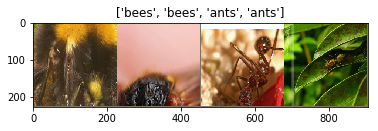

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 稍微暂停以便更新图表


# 获得一批训练数据
inputs, classes = next(iter(dataloaders['train']))

# 在一批数据中分出小格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

训练模型
------------------

现在写一些通用函数来训练一个模型。此处，我们会阐述：

-  调整学习率
-  保存最佳模型

在下文，参数**scheduler**是一个学习率调整的对象，来自**torch.optim.lr_scheduler**



In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每次迭代有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # 模型设置为训练模式
            else:
                model.eval()   # 模型设置为评估模式

            running_loss = 0.0
            running_corrects = 0

            # 数据上迭代
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零参数梯度
                optimizer.zero_grad()

                # 前向
                # 只在训练时追踪历史
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 仅在训练阶段，反向与优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深拷贝模型
            if phase == 'val' and epoch_acc > best_acc: # 本次迭代的准确率是目前最优的，存储最佳模型
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 装载最佳模型
    model.load_state_dict(best_model_wts)
    return model

### 可视化模型预测

展示对一些图像的预测的通用函数




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

调整卷积神经网络
----------------------

装载一个预训练模型并重置最后的全连接层。




In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 注意所有参数都被优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7次迭代衰减学习率0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\舒意恒/.torch\models\resnet18-5c106cde.pth
100.0%


### 训练与评估

会花费 CPU 15-25 分钟时间，使用 GPU 在 1 分钟以内。




In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6189 Acc: 0.7049
val Loss: 0.2109 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.7507 Acc: 0.7049
val Loss: 0.3695 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4591 Acc: 0.8115
val Loss: 0.4246 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4351 Acc: 0.8197
val Loss: 0.3256 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.3779 Acc: 0.8566


KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)

卷积神经网络作为固定特征提取器
----------------------------------

冻结整个网络，除了最后一层。我们需要将 ``requires_grad == False`` 以冻结参数，梯度不会被计算在``backward()``中。

了解更多[点击此处](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 默认情况下，新构建的模块的参数具有 requires_grad = True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 注意只有最后一层的参数才会被优化，这与之前不同
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每7次迭代，学习率衰退0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练和评估

与之前场景相比，在 CPU 上这将花费约一半时间，因为网络大部分不需要计算梯度。

然而，前向传播是必须计算的。




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()